### Example use of time-dependent global sensitivity analysis (TDGSA) package

We show the use of the TDGSA package on a simple oscillator example from Alexanderian et al [1]. The oscillator model is governed by the IVP

$\frac{d^2y}{dt^2} + 2\alpha\frac{dy}{dt}+(\alpha^2+\beta^2)y=0$,

$y(0) = \ell, \, \, \frac{dy(0)}{dt}=0$.

The parameters $\alpha$, $\beta$, and $\ell$ are uncertain and distributed according to

$\alpha \sim \mathcal{U}(\frac{3}{8}, \frac{5}{8})$,

$\beta \sim \mathcal{U}(\frac{10}{4}, \frac{15}{4})$,

$\ell \sim \mathcal{U}(-\frac{5}{4}, -\frac{3}{4})$.

[1] Alexanderian, A.; Gremaud, P. A.; Smith, R. C. Variance-Based Sensitivity Analysis for Time-Dependent Processes. Reliability Engineering & System Safety 2020, 196, 106722. https://doi.org/10.1016/j.ress.2019.106722.


In [1]:
from TDGSA import simulator, distribution, time_dependent_sensitivity_analysis

import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import seaborn as sns

#===============================================================================#
# Define the parameter distribution and model of interest
#===============================================================================#

NUM_TIMESTEPS_SOLVER = 200
num_timesteps_quadrature = 100
num_samples = 1000

def my_model_numeric(param):
    def derivatives(x, t):
        return [x[1],-2*param[0]*x[1]-(param[0]**2 + param[1]**2)*x[0]]
    time = np.linspace(0,10,NUM_TIMESTEPS_SOLVER)
    displacement, velocity = odeint(derivatives, [param[2],0], time).T
    return displacement

## choose the analytic model to speed up computation
def my_model_analytic(param):
    time = np.linspace(0,10,NUM_TIMESTEPS_SOLVER)
    displacement = param[2]*np.exp(-param[0]*time)*(np.cos(param[1]*time)+param[0]/param[1]*np.sin(param[1]*time))
    return displacement


my_dist_dict = {
    r"$\alpha$": ("uniform", [3/8, 5/8]),
    r"$\beta$": ("uniform", [10/4, 15/4]),
    r"$\ell$": ("uniform", [-5/4, -3/4])
}

my_distribution = distribution(my_dist_dict)
my_simulator = simulator(my_model_numeric, timesteps_solver=np.linspace(0,10,NUM_TIMESTEPS_SOLVER))
my_tdsa = time_dependent_sensitivity_analysis(my_simulator, my_distribution, num_timesteps_quadrature=num_timesteps_quadrature)

#===============================================================================#
# Sample parameter vectors and run the simulator
#===============================================================================#

my_params, my_output = my_tdsa.sample_params_and_run_simulator(num_samples)

/home/elia/TDGSA/TDGSA/utils.py:12: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


Sampling parameters ...

Running simulator ...



100%|██████████| 1000/1000 [00:00<00:00, 1465.90it/s]


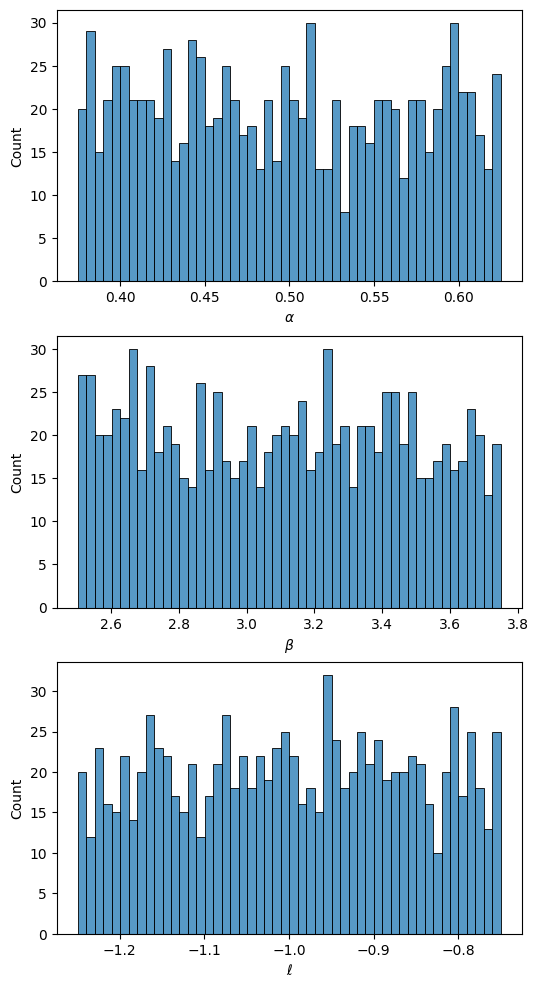

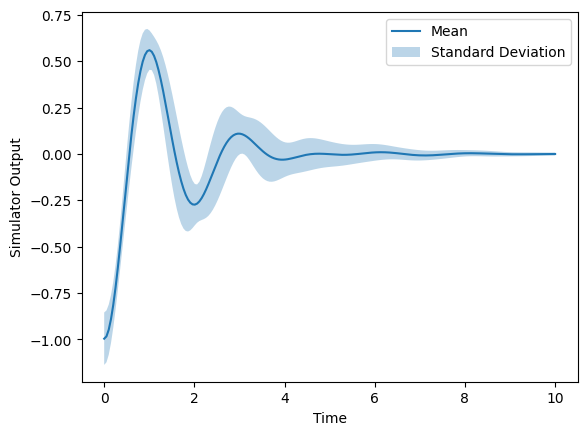

In [2]:
## Plot sampled parameters
my_tdsa.plot("sampled_parameters")

## Plot simulator output
my_tdsa.plot("simulator_output")

Generating PCE expansion ...

Fitting surrogate models ...



100%|██████████| 8/8 [00:00<00:00, 3394.82it/s]


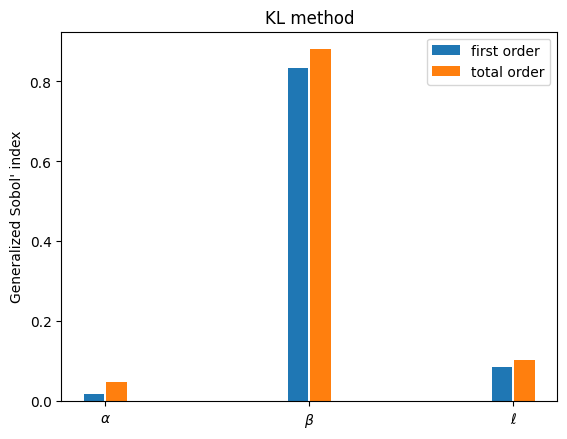

In [3]:
#===============================================================================#
# Compute the time-dependent sensitivity indices using 'KL'
#===============================================================================#

sobol_indices_KL = my_tdsa.compute_sobol_indices("KL")

# plot final Sobol' indices
my_tdsa.plot("sobol_indices")


Generating PCE expansion ...

Fitting surrogate models ...



100%|██████████| 100/100 [00:00<00:00, 403.82it/s]


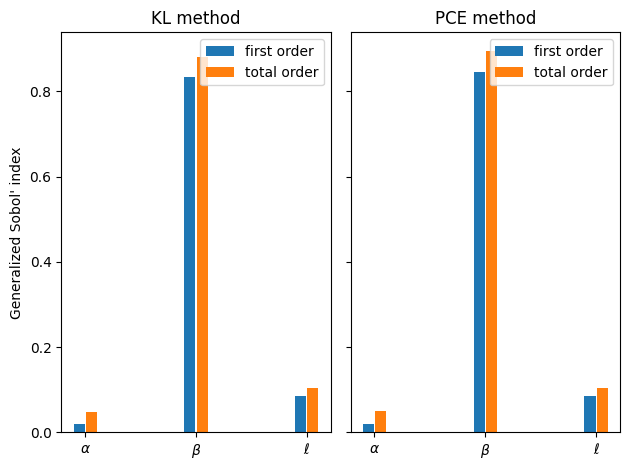

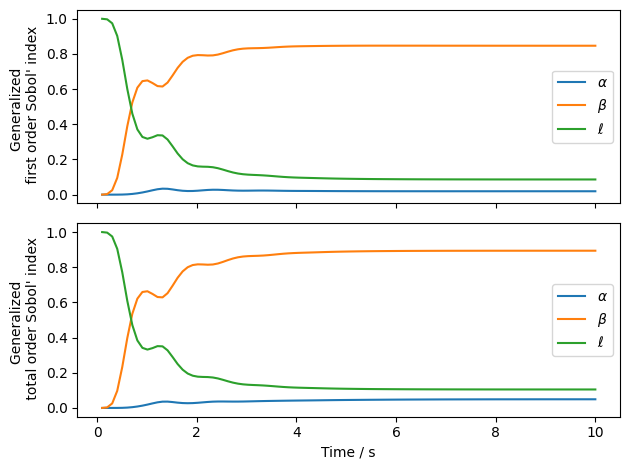

In [4]:
#===============================================================================#
# Compute the time-dependent sensitivity indices using 'PCE'
#===============================================================================#

sobol_indices_PCE = my_tdsa.compute_sobol_indices("PCE")

# plot final Sobol' indices
my_tdsa.plot("sobol_indices")

# plot time evolution of Sobol' indices
my_tdsa.plot("time_dependent_sobol_indices")

Text(0, 0.5, "Generalized total order Sobol' indices")

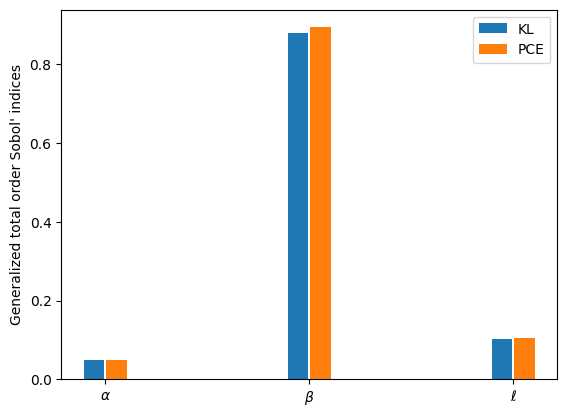

In [5]:
#========================================================================================#
# Compare the time-dependent total sensitivity indices computed using different methods
#========================================================================================#

plt.figure()
x = np.array([1,2,3])
plt.bar(x-0.055, sobol_indices_KL["total"], width=0.1, label="KL")
plt.bar(x+0.055, sobol_indices_PCE["total"], width=0.1, label="PCE")
plt.xticks([1,2,3], [r"$\alpha$", r"$\beta$", r"$\ell$"])
plt.legend()
plt.ylabel("Generalized total order Sobol' indices")

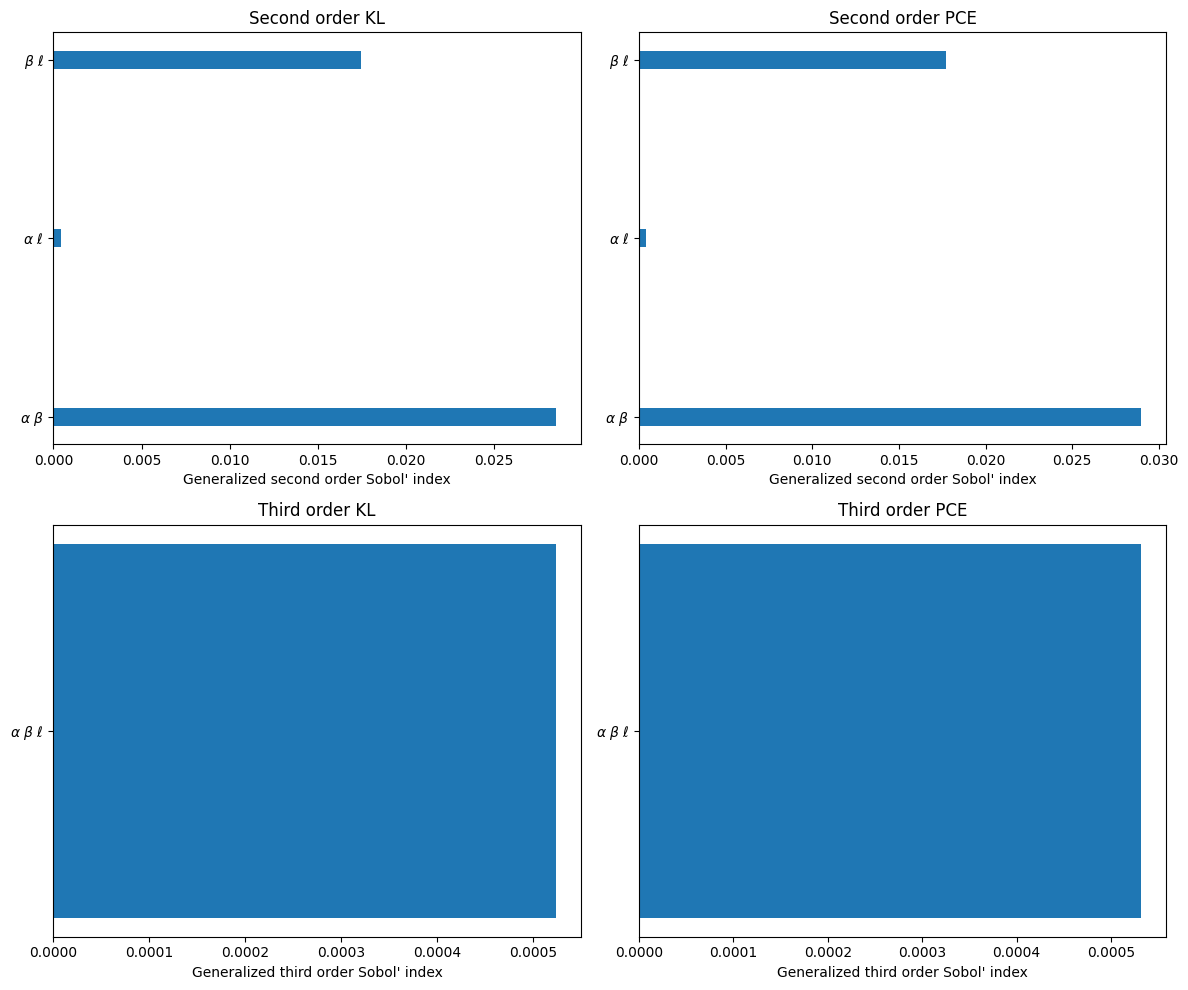

In [6]:
#===============================================================================#
# Compute second and third order Sobol' indices
#===============================================================================#

second_order, params = my_tdsa.compute_second_order_sobol_indices("PCE")
third_order, params = my_tdsa.compute_second_order_sobol_indices("KL")
third_order, params = my_tdsa.compute_third_order_sobol_indices("PCE")
second_order, params = my_tdsa.compute_third_order_sobol_indices("KL")

# plot higher order Sobol' indices
my_tdsa.plot("higher_order_sobol_indices")

100%|██████████| 3/3 [00:00<00:00, 2319.43it/s]


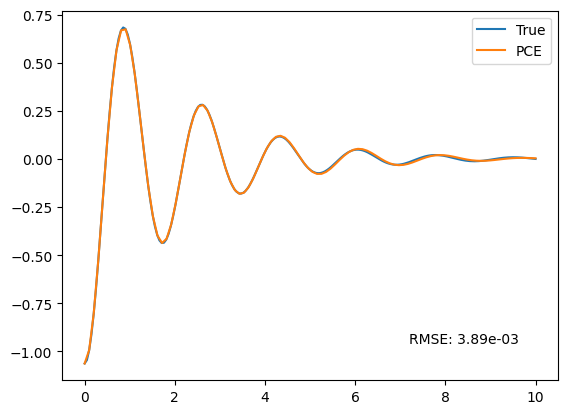

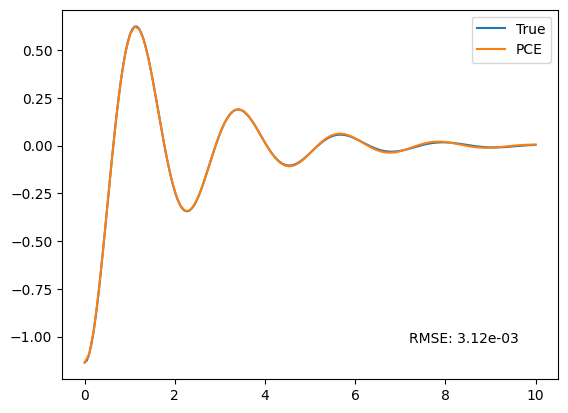

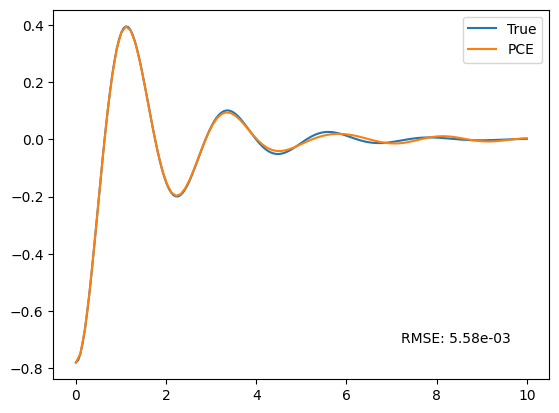

In [7]:
#===============================================================================#
# Test PCE surrogate model quality
#===============================================================================#

from sklearn.metrics import root_mean_squared_error

params = my_distribution.dist.sample(3).T

results = my_simulator.run(params)

result1 = results[0]
result2 = results[1]
result3 = results[2]

PCE_result1 = my_tdsa.evaluate_surrogate_model(params[0], method="PCE")
PCE_result2 = my_tdsa.evaluate_surrogate_model(params[1], method="PCE")
PCE_result3 = my_tdsa.evaluate_surrogate_model(params[2], method="PCE")

result1_interp = np.interp(np.linspace(0,10,num_timesteps_quadrature), np.linspace(0,10,NUM_TIMESTEPS_SOLVER), result1)
result2_interp = np.interp(np.linspace(0,10,num_timesteps_quadrature), np.linspace(0,10,NUM_TIMESTEPS_SOLVER), result2)
result3_interp = np.interp(np.linspace(0,10,num_timesteps_quadrature), np.linspace(0,10,NUM_TIMESTEPS_SOLVER), result3)

rms1 = root_mean_squared_error(result1_interp, PCE_result1)
rms2 = root_mean_squared_error(result2_interp, PCE_result2)
rms3 = root_mean_squared_error(result3_interp, PCE_result3)

plt.figure()
plt.plot(np.linspace(0,10,NUM_TIMESTEPS_SOLVER), result1, label="True")
plt.plot(np.linspace(0,10,num_timesteps_quadrature), PCE_result1, label="PCE")
plt.text(0.7, 0.1, f"RMSE: {rms1:.2e}", transform=plt.gca().transAxes)
plt.legend()

plt.figure()
plt.plot(np.linspace(0,10,NUM_TIMESTEPS_SOLVER), result2, label="True")
plt.plot(np.linspace(0,10,num_timesteps_quadrature), PCE_result2, label="PCE")
plt.text(0.7, 0.1, f"RMSE: {rms2:.2e}", transform=plt.gca().transAxes)
plt.legend()

plt.figure()
plt.plot(np.linspace(0,10,NUM_TIMESTEPS_SOLVER), result3, label="True")
plt.plot(np.linspace(0,10,num_timesteps_quadrature), PCE_result3, label="PCE")
plt.text(0.7, 0.1, f"RMSE: {rms3:.2e}", transform=plt.gca().transAxes)
plt.legend()


100%|██████████| 3/3 [00:00<00:00, 2307.10it/s]


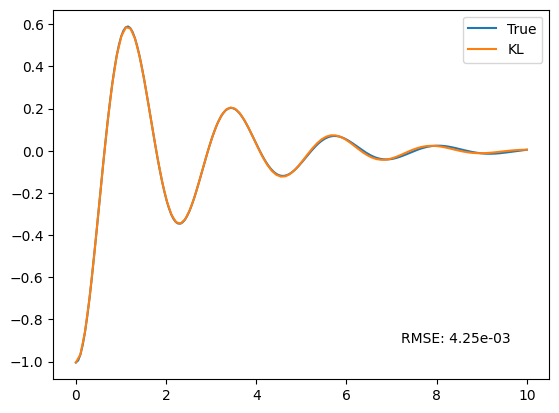

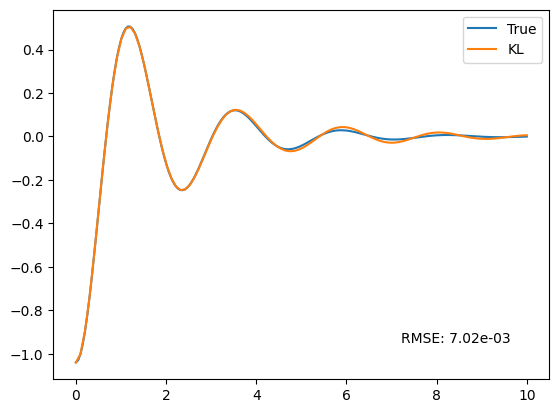

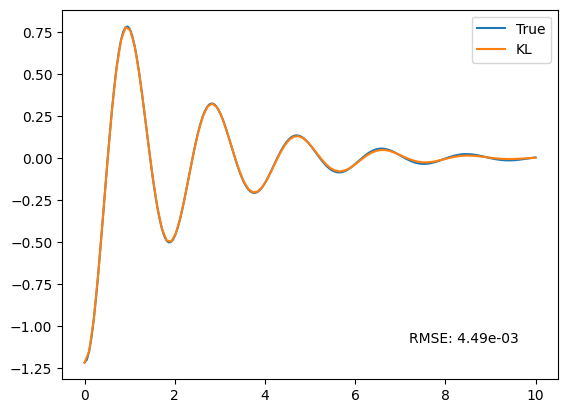

In [8]:
#===============================================================================#
# Test KL surrogate model quality
#===============================================================================#

from sklearn.metrics import root_mean_squared_error

params = my_distribution.dist.sample(3).T

results = my_simulator.run(params)

result1 = results[0]
result2 = results[1]
result3 = results[2]

KL_result1 = my_tdsa.evaluate_surrogate_model(params[0], method="KL")
KL_result2 = my_tdsa.evaluate_surrogate_model(params[1], method="KL")
KL_result3 = my_tdsa.evaluate_surrogate_model(params[2], method="KL")

result1_interp = np.interp(np.linspace(0,10,num_timesteps_quadrature), np.linspace(0,10,NUM_TIMESTEPS_SOLVER), result1)
result2_interp = np.interp(np.linspace(0,10,num_timesteps_quadrature), np.linspace(0,10,NUM_TIMESTEPS_SOLVER), result2)
result3_interp = np.interp(np.linspace(0,10,num_timesteps_quadrature), np.linspace(0,10,NUM_TIMESTEPS_SOLVER), result3)

rms1 = root_mean_squared_error(result1_interp, KL_result1)
rms2 = root_mean_squared_error(result2_interp, KL_result2)
rms3 = root_mean_squared_error(result3_interp, KL_result3)

plt.figure()
plt.plot(np.linspace(0,10,NUM_TIMESTEPS_SOLVER), result1, label="True")
plt.plot(np.linspace(0,10,num_timesteps_quadrature), KL_result1, label="KL")
plt.text(0.7, 0.1, f"RMSE: {rms1:.2e}", transform=plt.gca().transAxes)
plt.legend()

plt.figure()
plt.plot(np.linspace(0,10,NUM_TIMESTEPS_SOLVER), result2, label="True")
plt.plot(np.linspace(0,10,num_timesteps_quadrature), KL_result2, label="KL")
plt.text(0.7, 0.1, f"RMSE: {rms2:.2e}", transform=plt.gca().transAxes)
plt.legend()

plt.figure()
plt.plot(np.linspace(0,10,NUM_TIMESTEPS_SOLVER), result3, label="True")
plt.plot(np.linspace(0,10,num_timesteps_quadrature), KL_result3, label="KL")
plt.text(0.7, 0.1, f"RMSE: {rms3:.2e}", transform=plt.gca().transAxes)
plt.legend()

In [9]:
tdgsa_KL = time_dependent_sensitivity_analysis(my_simulator, my_distribution)
my_params, my_output = tdgsa_KL.sample_params_and_run_simulator(num_samples)

tdgsa_PCE = time_dependent_sensitivity_analysis(my_simulator, my_distribution, data=(my_params, my_output))
tdgsa_PCE.compute_sobol_indices("PCE")

Sampling parameters ...

Running simulator ...



100%|██████████| 1000/1000 [00:00<00:00, 6409.02it/s]


Generating PCE expansion ...

Fitting surrogate models ...



100%|██████████| 100/100 [00:00<00:00, 447.31it/s]


,first,total
$\alpha$,0.019188,0.049168
$\beta$,0.847048,0.894015
$\ell$,0.086345,0.104791
